# Surface processing

***Create layer surfaces***
Uses FreeSurfer mris-inflate. Based on the number of surfaces you specify. Each will be approximately equidistant. Vertex correspondence is maintained, i.e each layer will have vertices along the vector connecting a white matter surface vertex with the corresponding pial surface vertex. Each surface will then be converted to gifti format and the vertex coordinates will adjusted by the RAS at the center of the volume to put them in native space.

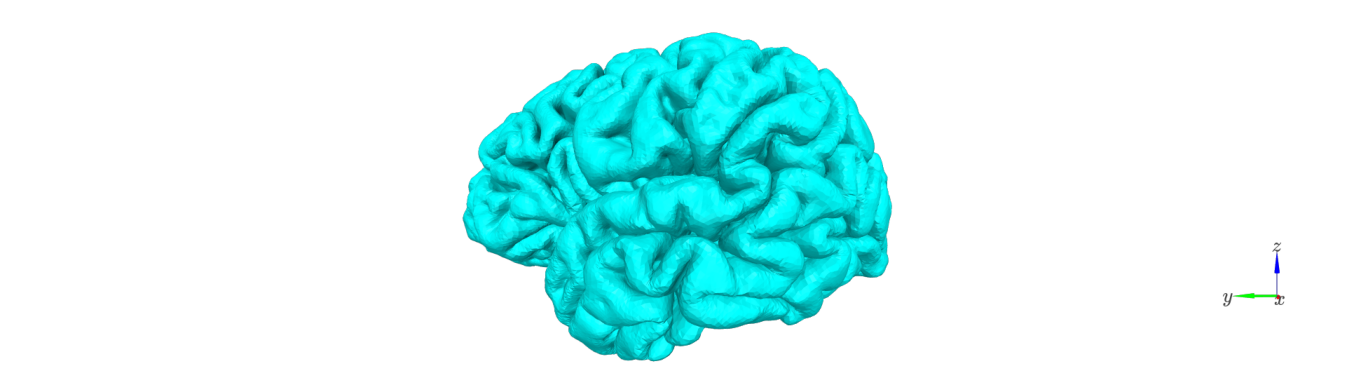

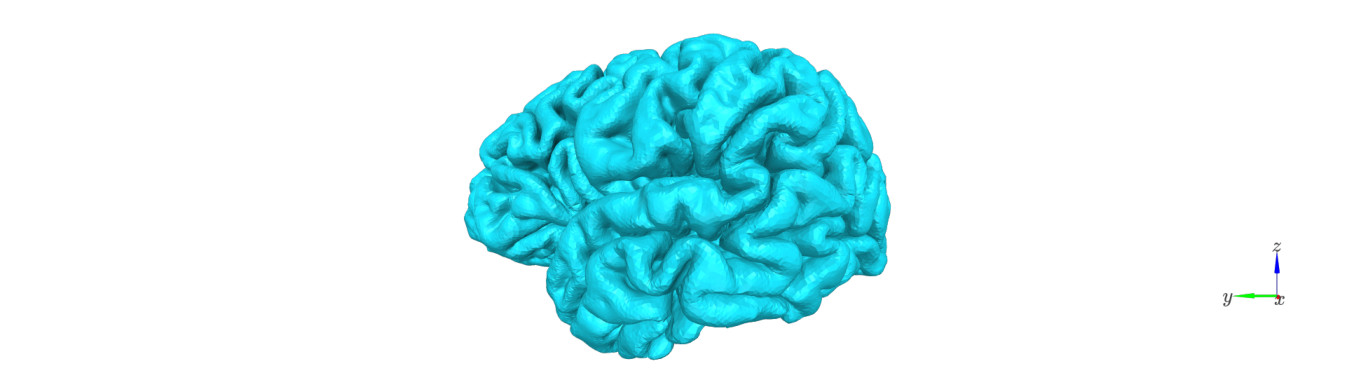

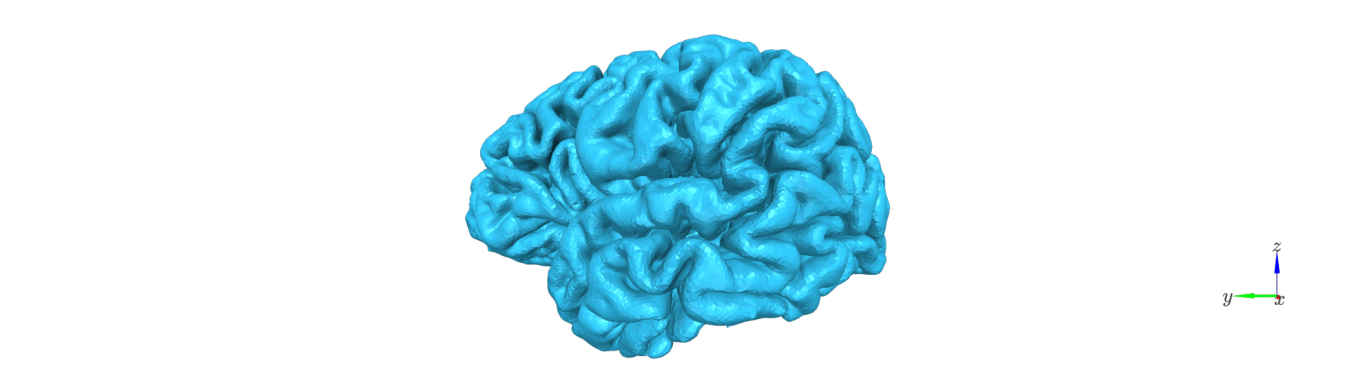

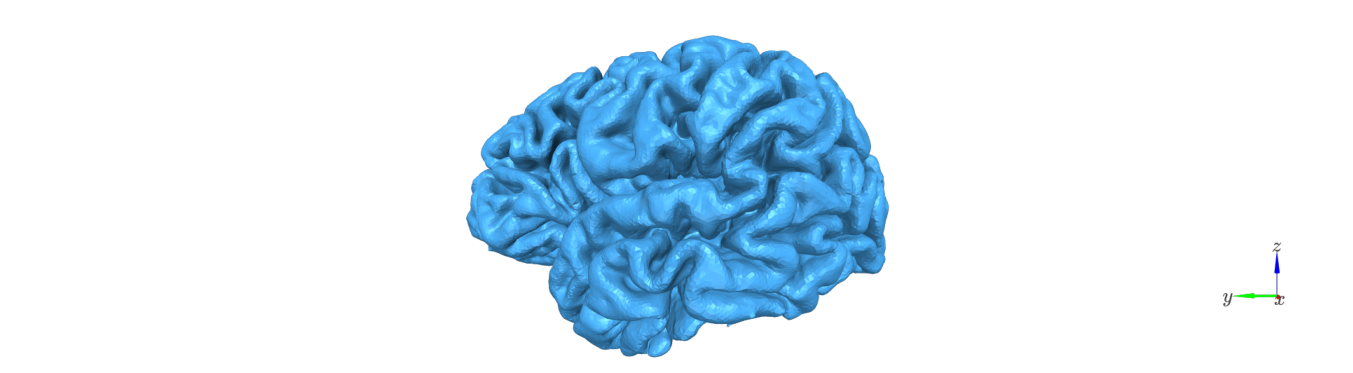

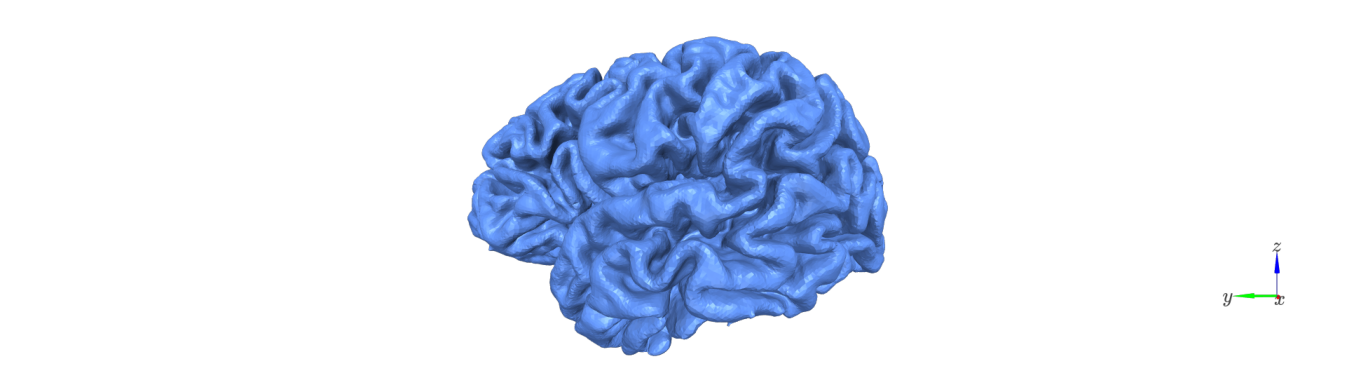

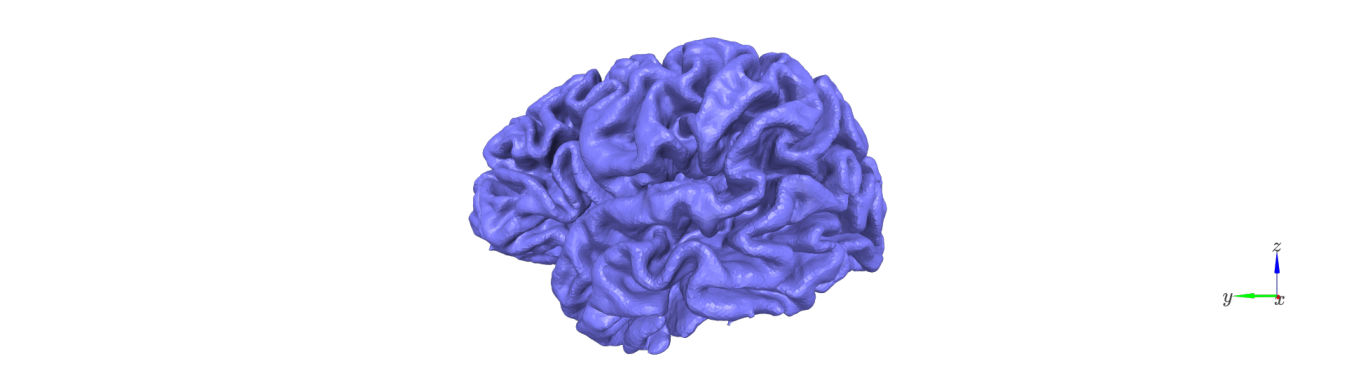

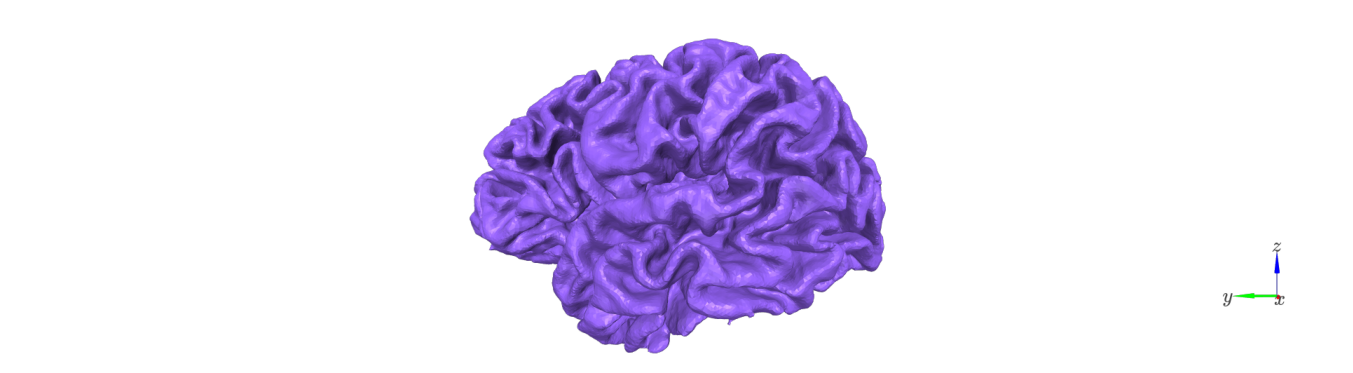

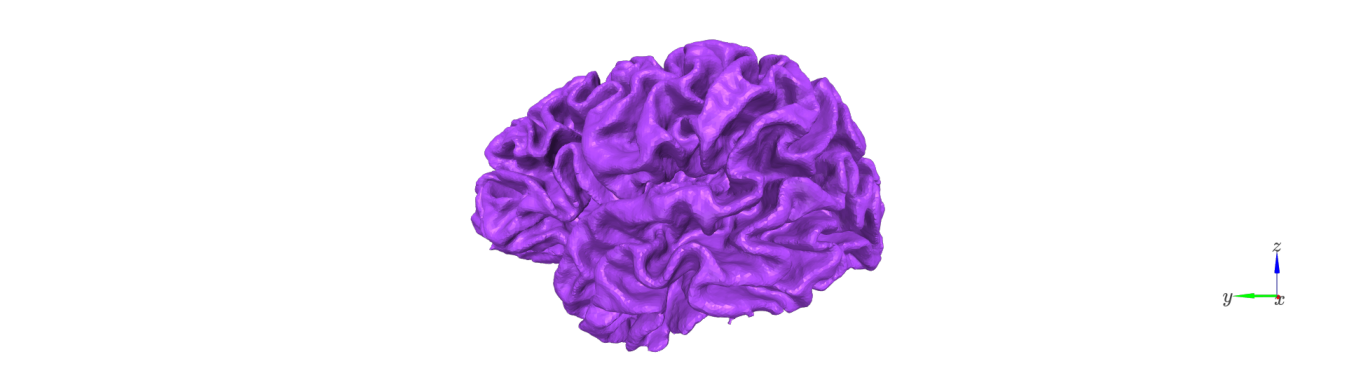

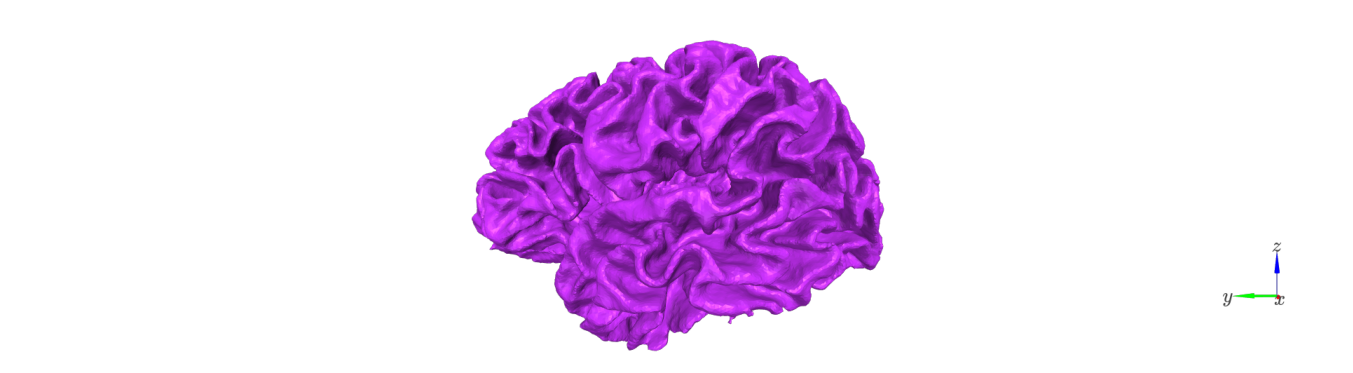

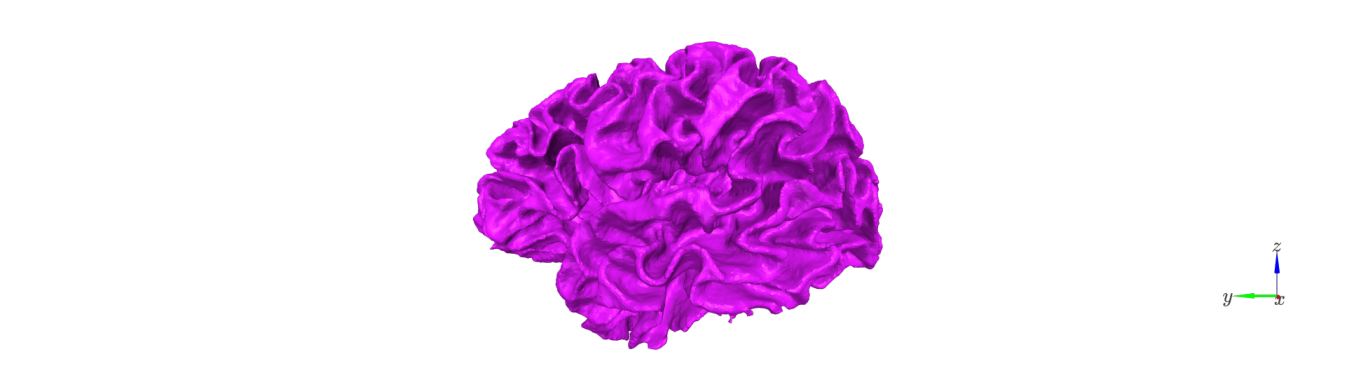

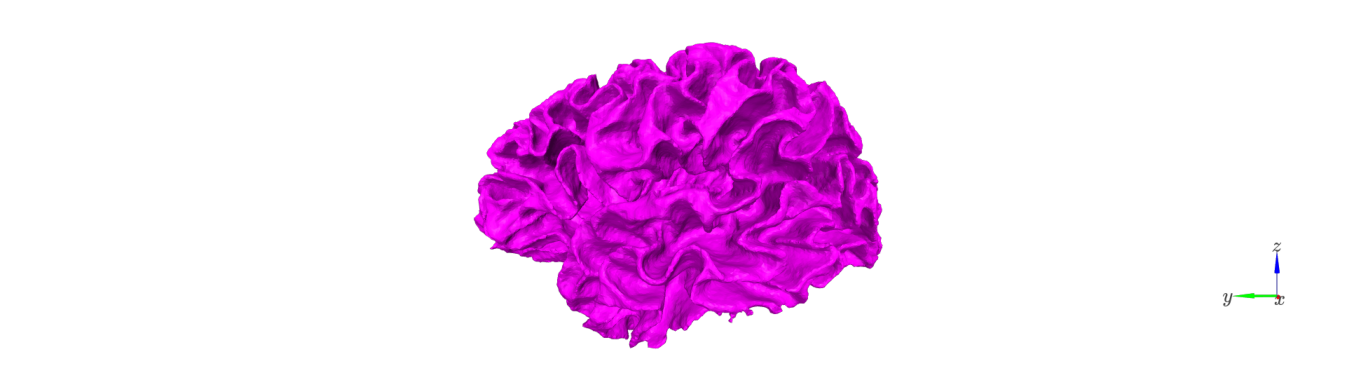

In [41]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from lameg.viz import show_surface, rgbtoint

# Get name of each mesh that makes up the layers of the multilayer mesh
n_layers = 11
layers = np.linspace(1, 0, n_layers)

surf_path = '../test_output/sub-104/'
layer_fnames = []
for l, layer in enumerate(layers):
    if layer == 1:
        layer_fnames.append(os.path.join(surf_path, f'lh.pial.initial.gii'))
    elif layer > 0 and layer < 1:
        layer_name = '{:.3f}'.format(layer)
        layer_fnames.append(os.path.join(surf_path, f'lh.{layer_name}.initial.gii'))
    elif layer == 0:
        layer_fnames.append(os.path.join(surf_path, f'lh.white.initial.gii'))

cam_view=[-143, 14, 31.5,
          -32, 22.5, 38.5,
          0, 0, 1]
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))

for l_idx,layer_fname in enumerate(layer_fnames):
    mesh = nib.load(layer_fname)
    plot = show_surface(mesh, camera_view=cam_view, color=col_r[l_idx,:3]*255, height=256)

***Remove deep vertices***
Freesurfer operates on hemispheres independently, resulting in deep vertices and mesh faces cutting through subcortical structures. These are removed because they are not part of the cortical source space. Any vertex not labelled or labelled as unknown in the Desikan-Killiany atlas are removed. This is applied to each hemisphere of each layer mesh.

****Before****
![pre remove deep](../doc/img/screenshot_lh.pial.pre_remove_deep.png "pial surface before removing deep vertices")

****After****
![post remove deep](../doc/img/screenshot_lh.pial.post_remove_deep.png "pial surface after removing deep vertices")

In [ ]:
for idx in range(len(plots)):
    plots[idx].fetch_screenshot()    

In [ ]:
import matplotlib.pyplot as plt
import io
import numpy as np
from PIL import Image
from base64 import b64decode

for plot in plots:
    # Decode the base64 encoded screenshot
    image_data = b64decode(plot.screenshot)

    # Convert byte data to image
    image = Image.open(io.BytesIO(image_data))

    # Convert image to NumPy array
    image_array = np.array(image)

    # Display the image using Matplotlib
    plt.figure(figsize=(24,16))
    plt.imshow(image_array)
    plt.axis('off')  # To turn off the axis
    plt.show()

***Combine hemispheres***
The left and right hemisphere meshes are combined by concatenation of their vertices and faces (left then right). No new faces are created. This is done for each layer.

![combined pial](../doc/img/screenshot_combined.pial.png "pial combined hemisphere surface")

***Downsample***
The surfaces are much too dense to use in source reconstruction. They must be downsampled, but we must maintain vertex correspondence between them (see [Bonaiuto et al. 2020, Estimates of cortical column orientation improve MEG source inversion](https://doi.org/10.1016/j.neuroimage.2020.116862)). The pial surface is therefore downsampled by a factor of 10 using the vtkDecimatePro algorithm, which only removes vertices rather than creating new ones. The removed vertices are also removed from each other layer mesh, and the face structure from the pial mesh is copied to them (though the faces are not used in the source reconstruction if link vector orientations are used).

![ds pial](../doc/img/screenshot_pial.ds.png "downsampled pial surface")

***Compute link vectors***
The dipole orientation at each source location is computed. Downsampled surface normals, original surface normals, cortical patch statistics, or link vectors can be specified (see [Bonaiuto et al. 2020, Estimates of cortical column orientation improve MEG source inversion](https://doi.org/10.1016/j.neuroimage.2020.116862)). The first three compute vertex normals based on the orientation of the surrounding faces. They can be either computed separately for each layer, or the pial surface orientations can be used for all layers. The link vectors method computes vectors connecting corresponding pial and white matter vertices (pointing toward the white matter), which are therefore the same across layer. The orientation vectors are stored in the normals attribute of the gifti object.

![link vectors](../doc/img/screenshot_link_vectors.png "link vectors")

***Combine layers***
The layer meshes are then combined into a single mesh by concatenating their vertices and faces (from pial to white matter). No new faces are created (i.e. there are no edges connecting vertices across layers)

![multilayer](../doc/img/screenshot_multilayer.png "multilayer")

# Putting it all together
All of these steps can be run using the function:
> postprocess_freesurfer_surfaces

In [26]:
from lameg.surf import postprocess_freesurfer_surfaces

# Create a 2-layer surface (only pial and white)
postprocess_freesurfer_surfaces(
    'sub-104',                                
    './test_output',                                
    'multilayer.2.ds.link_vector.gii',                                
    n_surfaces=2,                                 
    ds_factor=0.1,                                 
    orientation='link_vector',                                 
    remove_deep=True
)

[ 2.02536 36.9153  16.8828 ]
100.0% of the vertices in the decimated surface belong to the original surface.


In [27]:
# Create an 11-layer surface
postprocess_freesurfer_surfaces(
    'sub-104',                                
    './test_output',
    'multilayer.11.ds.link_vector.gii',
    n_surfaces=11, 
    ds_factor=0.1, 
    orientation='link_vector', 
    remove_deep=True
)

[ 2.02536 36.9153  16.8828 ]
100.0% of the vertices in the decimated surface belong to the original surface.


In [28]:
# Create a 32-layer surface
postprocess_freesurfer_surfaces(
    'sub-104',                                
    './test_output',
    'multilayer.32.ds.link_vector.gii',
    n_surfaces=32, 
    ds_factor=0.1, 
    orientation='link_vector', 
    remove_deep=True
)

[ 2.02536 36.9153  16.8828 ]
100.0% of the vertices in the decimated surface belong to the original surface.
